# Taller 7 Red Neuronal MLP


Enlace de del desarroyo mostrado en este cuaderno:      <a href="https://colab.research.google.com/github/JCardenas05/Teoria_Se-ales/blob/main/Taller_5/Taller_7_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab This NoteBook"/></a>


### A continuación se presenta una alternativa de solución en el siguiente enlace

Desarrollo del ejercido implementando una red *MLPClassifier* del paquete de skakearn, esta implementa un algoritmo de perceptrón multicapa (MLP) que se entrena utilizando Retropropagación (Backpropagation):        <a href="https://colab.research.google.com/github/JCardenas05/Teoria_Se-ales/blob/main/14-11-2023/Ejercicio_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab This NoteBook"/></a>


---

- Jony Cardenas Herrera
- Brayan Avendaño Mesa

## Actividades
1. Crear una red neuronal multicapa (MLP)
    - Modelo implementado: red de clasificación binaria
    - Generación de datos
    - Normalización
    - Entrenamiento
    - Validación 
    
2. Evaluar el rendimiento para distintas representaciones de datos
    - $p(0) = p(1)$
    - $p(0) >> p(1)$
    - $N_1(x_1, \sigma_1) \neq N_2(x_2, \sigma_2) $
3. Agregar metricas de rendimiento
    - Matrix de confusión
    - Accuracy
    - Loss

In [7]:
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [8]:
def map_range(value, min_=0, max_=1):
    """
    Normaliza los valores de una matriz 'value' a un rango especificado por 'min_' y 'max_'.

    Parámetros:
    - value (array-like): Matriz de valores a normalizar.
    - min_ (float, opcional): Valor mínimo del rango de salida. Por defecto es 0.
    - max_ (float, opcional): Valor máximo del rango de salida. Por defecto es 1.

    Retorna:
    - array-like: Matriz de valores normalizados en el nuevo rango.
    """
    out_normalize = ((value-np.min(value))/(np.max(value)-np.min(value))) * (max_ - min_) 
    return value

def clearConsole():
    command = 'clear'  # Comando por defecto para sistemas Unix/Linux
    os.system(command)  # Ejecuta el comando para limpiar la consola

def predict_simbol(message_corrupt, modelo, Nsamples=500, simbols=(0,1)):
    """
    Predice símbolos binarios a partir de un mensaje corrupto utilizando un modelo de predicción.

    Parámetros:
    - message_corrupt (array-like): Mensaje corrupto que se necesita predecir.
    - modelo (modelo de aprendizaje automático): Modelo de predicción utilizado.
    - Nsamples (int, opcional): Número de muestras. Por defecto es 500.
    - simbols (tuple, opcional): Tupla con los símbolos binarios. Por defecto es (0,1).

    Retorna:
    - array-like: Mensaje predicho en forma de matriz de símbolos binarios.
    """
    message_predict = modelo.predict(message_corrupt).flatten()
    message_predict = np.where(message_predict >= 0.5, simbols[1], simbols[0])
    message_predict = np.repeat(message_predict, Nsamples)
    return message_predict

def generate_symbols(a0=0, a1=1, p_0=0.5, Nsamples=500, Nsymbols=100, var_noise=0.5, Diff=False):
    """
    Genera símbolos con ruido y los prepara para pruebas.

    Parámetros:
    - a0, a1 (float, opcional): Valores de los símbolos. Por defecto son 0 y 1.
    - p_0 (float, opcional): Probabilidad del símbolo 'a0'. Por defecto es 0.5.
    - Nsamples (int, opcional): Número de muestras por símbolo. Por defecto es 500.
    - Nsymbols (int, opcional): Número de símbolos. Por defecto es 100.
    - var_noise (float o tuple, opcional): Varianza del ruido. Puede ser un número o una tupla. Por defecto es 0.5.
    - Diff (bool, opcional): Si es True, aplica diferencia entre muestras consecutivas.

    Retorna:
    - tuple: Tres matrices correspondientes a los mensajes corruptos, los mensajes originales y el tiempo.
    """

    N=Nsamples*Nsymbols
    p_1 = 1 - p_0

    if type(var_noise) == tuple:
        data_test = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
        message_test_org = np.concatenate([[v]*Nsamples for v in data_test])
        message_test_corrupt = []

        noise_test_a0 = np.random.normal(0, var_noise[0], sum([1 for x in message_test_org if x == a0]))
        noise_test_a1 = np.random.normal(0, var_noise[1], sum([1 for x in message_test_org if x == a1]))

        for i in message_test_org:

            if i == a0:
                noise_simbol = noise_test_a0[0]
                noise_test_a0 = np.delete(noise_test_a0, 0)
            elif i == a1:
                noise_simbol = noise_test_a1[0]
                noise_test_a1 = np.delete(noise_test_a1, 0)

            message_test_corrupt.append(i + noise_simbol)
        message_test_corrupt = np.array(message_test_corrupt)
        
    else:
        noise_test = np.random.normal(0, var_noise, N)
        data_test = np.random.choice([a0, a1], size=Nsymbols, p=[p_0, p_1])
        message_test_org = np.concatenate([[v]*Nsamples for v in data_test])
        message_test_corrupt = message_test_org + noise_test
        message_test_corrupt = map_range(message_test_corrupt)

    message_test_corrupt = np.array(np.split(message_test_corrupt, Nsymbols))

    if Diff == True:
        message_test_org_ = np.array(np.split(message_test_org, Nsymbols))

        '''
        # Calcula la diferencia absoluta entre elementos consecutivos en el eje 0 (verticalmente).
        # El 'prepend=0' añade un 0 al inicio para mantener la dimensión constante.
        # Esta operación podría estar detectando cambios o transiciones en la señal o datos.

        La primera diferencia la da out[i] = a[i+1] - a[i]A lo largo el eje dado, las diferencias más elevadas se calculan mediante el uso de diffrecursivamente.
        '''
        
        message_test_org_ = np.abs(np.diff(message_test_org_, axis=0, prepend=0))

        message_test_corrupt = message_test_org_.flatten() + noise_test
        message_test_corrupt = map_range(message_test_corrupt)
        message_test_corrupt = np.array(np.split(message_test_corrupt, Nsymbols))
        message_test_org_ = message_test_org_.flatten()
        message_test_org = (message_test_org, message_test_org_)

    time = np.linspace(0,N,N)
    return message_test_corrupt, message_test_org, time    

Simbolos por ruido: 200
Señal Corrupta entrenamiento: (4800, 500)
Señal Original entrenamiento: (4800, 500)
Señal Corrupta validación: (1200, 500)
Señal Original validación: (1200, 500)
Epoch 1/50
150/150 [==============================] - 5s 16ms/step - loss: 0.2431 - accuracy: 0.6762 - val_loss: 0.0588 - val_accuracy: 0.9425
Epoch 2/50
150/150 [==============================] - 2s 14ms/step - loss: 0.1075 - accuracy: 0.8654 - val_loss: 0.0246 - val_accuracy: 0.9858
Epoch 3/50
150/150 [==============================] - 2s 14ms/step - loss: 0.0640 - accuracy: 0.9271 - val_loss: 0.0175 - val_accuracy: 0.9892
Epoch 4/50
150/150 [==============================] - 2s 14ms/step - loss: 0.0477 - accuracy: 0.9463 - val_loss: 0.0147 - val_accuracy: 0.9883
Epoch 5/50
150/150 [==============================] - 2s 16ms/step - loss: 0.0352 - accuracy: 0.9615 - val_loss: 0.0130 - val_accuracy: 0.9892
Epoch 6/50
150/150 [==============================] - 2s 17ms/step - loss: 0.0289 - accuracy: 0.967

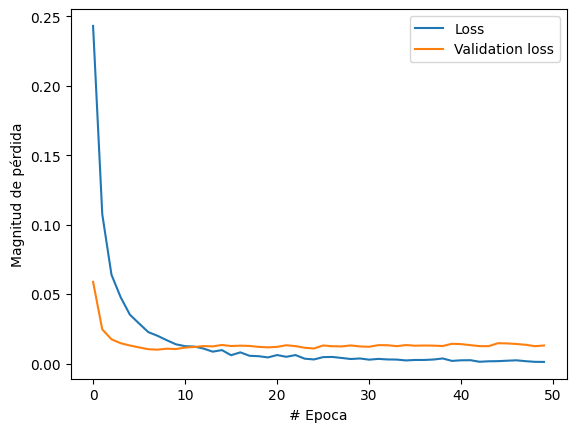

In [9]:
class Model_Predict_simbol:
    def __init__(self,Nsamples):
        self.Nsamples=Nsamples
        self.bluid_model()

    def bluid_model(self):
        entrada = tf.keras.layers.Dense(units=self.Nsamples, input_shape=(self.Nsamples,))
        dropout1 = tf.keras.layers.Dropout(0.3)  # Tasa de dropout del 30%
        capa1 = tf.keras.layers.Dense(units=100, activation='relu')
        dropout2 = tf.keras.layers.Dropout(0.3)  # Puedes ajustar la tasa según sea necesario
        capa2 = tf.keras.layers.Dense(units=50, activation='relu')
        dropout3 = tf.keras.layers.Dropout(0.3)
        capa3 = tf.keras.layers.Dense(units=25, activation='relu')
        salida = tf.keras.layers.Dense(units=1, activation='sigmoid')
        # Construcción del modelo
        self.modelo = tf.keras.Sequential([entrada, dropout1, capa1, dropout2, capa2, dropout3, capa3, salida])
        self.modelo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
               loss=tf.keras.losses.mean_squared_error,
               metrics=['accuracy'])
            

    def fill_model(self, symbol_0=0, symbol_1=1, metrics=False):

        Nsymbols = 6000 # Número total de símbolos
        points_noise = 30

        amp_noise=np.linspace(0.2,5,points_noise)

        message_org=[]
        message_corrupt=[]
        Nsymbols_noise=Nsymbols//points_noise

        print(f'Simbolos por ruido: {Nsymbols_noise}')

        for a in amp_noise:
            message_corrupt_, message_org_, _ = generate_symbols(symbol_0, symbol_1, Nsamples=self.Nsamples, Nsymbols=Nsymbols_noise, var_noise=a)
            message_corrupt.extend(message_corrupt_)
            message_org.extend(message_org_)
            
        message_org = np.array(np.split(np.array(message_org), Nsymbols))
        message_corrupt = map_range(np.array(message_corrupt), symbol_0, symbol_0)

        X_train, X_val, y_train, y_val = train_test_split(message_corrupt, message_org, test_size=0.2, random_state=42)
        print(f'Señal Corrupta entrenamiento: {X_train.shape}\nSeñal Original entrenamiento: {y_train.shape}')
        print(f'Señal Corrupta validación: {X_val.shape}\nSeñal Original validación: {y_val.shape}')
    
        historial = self.modelo.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
        
        if metrics == True:
            plt.xlabel("# Epoca")
            plt.ylabel("Magnitud de pérdida")
            plt.plot(historial.history["loss"], label='Loss')
            plt.plot(historial.history["val_loss"], label = 'Validation loss' )
            plt.legend()
            plt.show()
            

    def predict(self, signal, Nsamples, symbols=(0,1)):
        """
        Predice símbolos binarios a partir de un mensaje corrupto utilizando un modelo de predicción.

        Parámetros:
        - signal (array-like): Mensaje corrupto que se necesita predecir.
        - modelo (modelo de aprendizaje automático): Modelo de predicción utilizado.
        - Nsamples (int, opcional): Número de muestras. Por defecto es 500.
        - simbols (tuple, opcional): Tupla con los símbolos binarios. Por defecto es (0,1).

        Retorna:
        - array-like: Mensaje predicho en forma de matriz de símbolos binarios.
        """
        message_predict = self.modelo.predict(signal).flatten()
        message_predict = np.where(message_predict >= 0.5, symbols[1], symbols[0])
        message_predict = np.repeat(message_predict, Nsamples)
        return message_predict
    
    @staticmethod
    def plot_signals(predicted_signal, corrupt_signal=None, original_signal=None, time=None, Nsamples=None):
        """
        Plots the predicted, corrupt, and original signals.

        :param predicted_signal: The predicted signal.
        :param corrupt_signal: (Optional) The corrupt signal.
        :param original_signal: (Optional) The original signal.
        :param time: (Optional) Time array for x-axis. If None, a range based on the length of the predicted_signal is used.
        :param n_samples: (Optional) Number of samples for major tick interval on x-axis.
        """
        
        plt.figure(figsize=(12, 6), tight_layout=True)

        # Create a time range if not provided
        if time is None:
            time = np.linspace(0, len(predicted_signal), len(predicted_signal))

        # Plot the original signal if provided
        if original_signal is not None:
            plt.step(time, original_signal, 'g', label='Señal Original', alpha=0.6)

        # Plot the corrupt signal if provided
        if corrupt_signal is not None:
            plt.step(time, map_range(corrupt_signal).flatten(), 'b', label='Señal Corrupta', alpha=0.1)

        # Plot the predicted signal
        plt.step(time, predicted_signal, 'r', label='Señal Recuperada', alpha=0.6)

        # Set plot legend and grid
        plt.legend()
        if Nsamples is not None:
            plt.gca().xaxis.set_major_locator(plt.MultipleLocator(Nsamples))
        plt.grid(axis='x')  # Only vertical grid
        plt.show()

    @staticmethod
    def plt_cofusion_matrix(message_org, message_predict, Nsamples):
        conf_matrix = confusion_matrix(message_org, message_predict)/Nsamples
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
        plt.title('Matriz de Confusión')
        plt.xlabel('Predicciones')
        plt.ylabel('Valores Reales')
        plt.show()

Classifier_TF = Model_Predict_simbol(500)
Classifier_TF.fill_model(metrics=True)  

## 1) Generar simboloas con la misma probabiliadd $P(0) = P(1)$

7/7 [==============================] - 0s 5ms/step


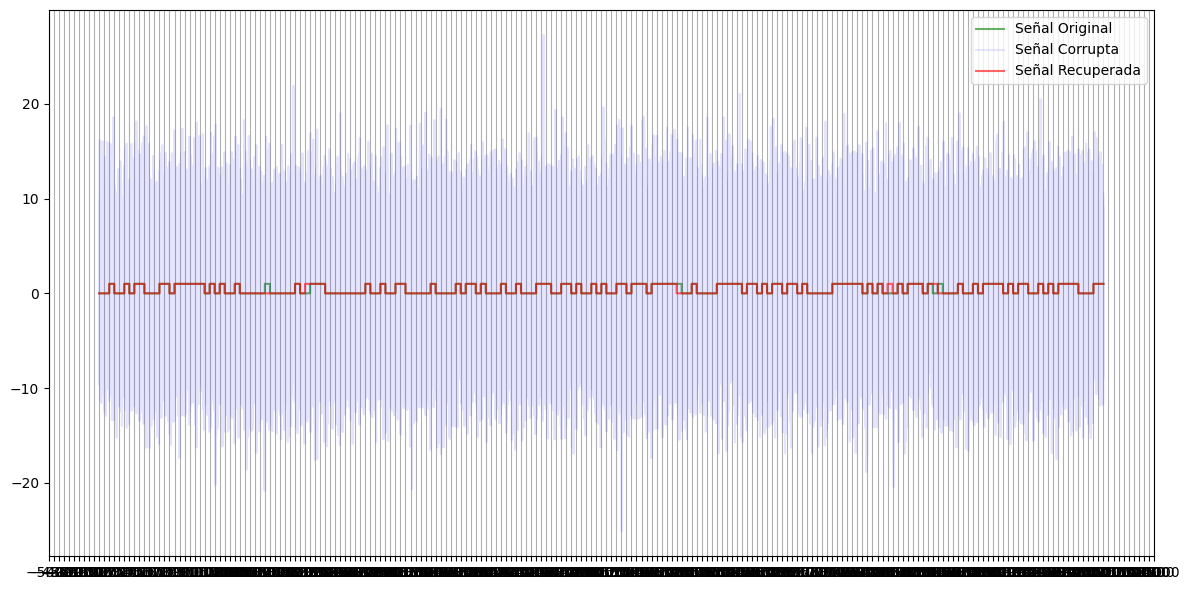

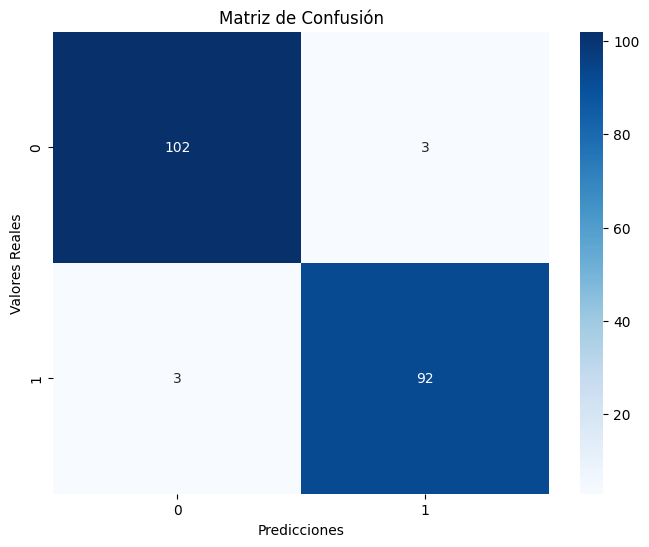

In [13]:
Nsamples = 500
message_corrupt_1, message_org_1, time_1 = generate_symbols(Nsamples=Nsamples, var_noise=5, Nsymbols=200)
message_predict_1 = Classifier_TF.predict(message_corrupt_1, Nsamples=Nsamples)

Model_Predict_simbol.plot_signals(message_predict_1, message_corrupt_1, message_org_1, time_1, Nsamples=Nsamples)
Model_Predict_simbol.plt_cofusion_matrix(message_org_1, message_predict_1, Nsamples)

## 2) Generar una secuencia de simbolos $0$ y $1$ con $P(0) >> p(1)$

16/16 [==============================] - 0s 5ms/step


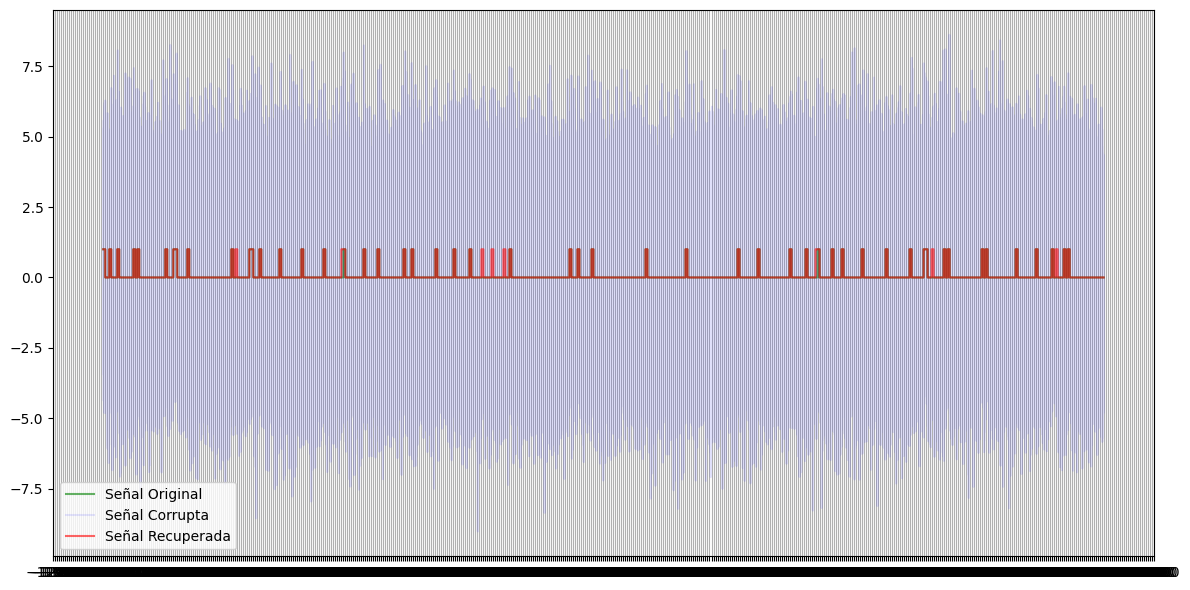

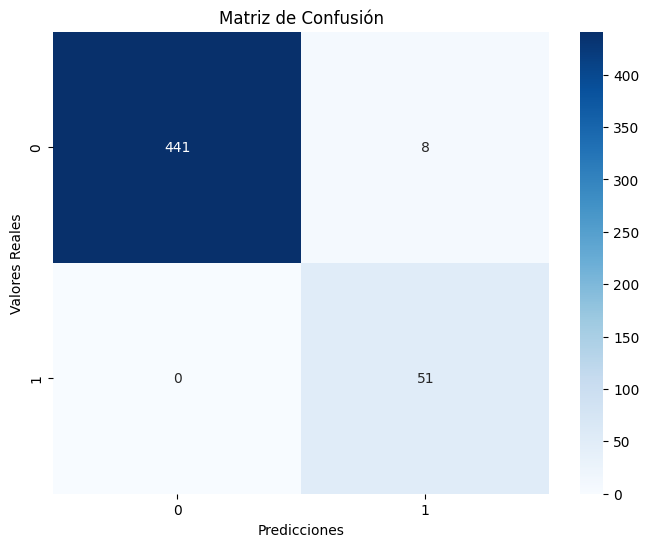

In [16]:
Nsamples = 500
p_0 = 0.9
message_corrupt_1, message_org_1, time_1 = generate_symbols(Nsamples=Nsamples, var_noise=2, Nsymbols=500, p_0=p_0)
message_predict_1 = Classifier_TF.predict(message_corrupt_1, Nsamples=Nsamples)

Model_Predict_simbol.plot_signals(message_predict_1, message_corrupt_1, message_org_1, time_1, Nsamples=Nsamples)
Model_Predict_simbol.plt_cofusion_matrix(message_org_1, message_predict_1, Nsamples)

## 3) Ruidos con varianza difernete para cada simbolo: $N_1(x_1, \sigma_1) \neq N_2(x_2, \sigma_2) $

7/7 [==============================] - 0s 7ms/step


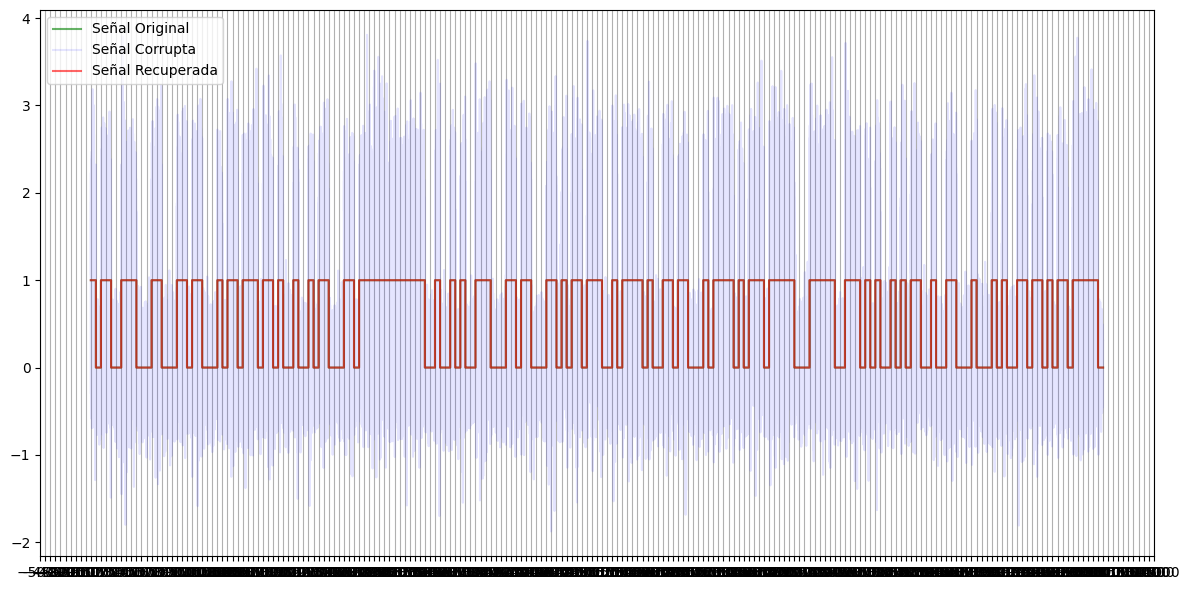

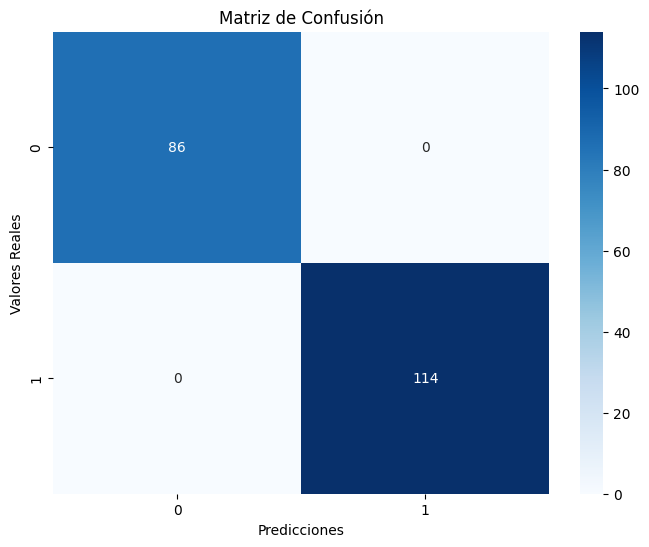

In [18]:
message_corrupt_3, message_orig_3, time_3 = generate_symbols(Nsymbols=200, p_0=0.5, Nsamples=Nsamples, var_noise=(0.3, 0.7)) 

message_predict_3 = Classifier_TF.predict(message_corrupt_3, Nsamples=Nsamples)

Model_Predict_simbol.plot_signals(message_predict_3, message_corrupt_3, message_orig_3, time_3, Nsamples=Nsamples)
Model_Predict_simbol.plt_cofusion_matrix(message_orig_3, message_predict_3, Nsamples)

## 4) Representación Diferencial: $N_1(0,\sigma_1)-N_2(0,\sigma_2)=0$  

2/2 [==============================] - 0s 6ms/step


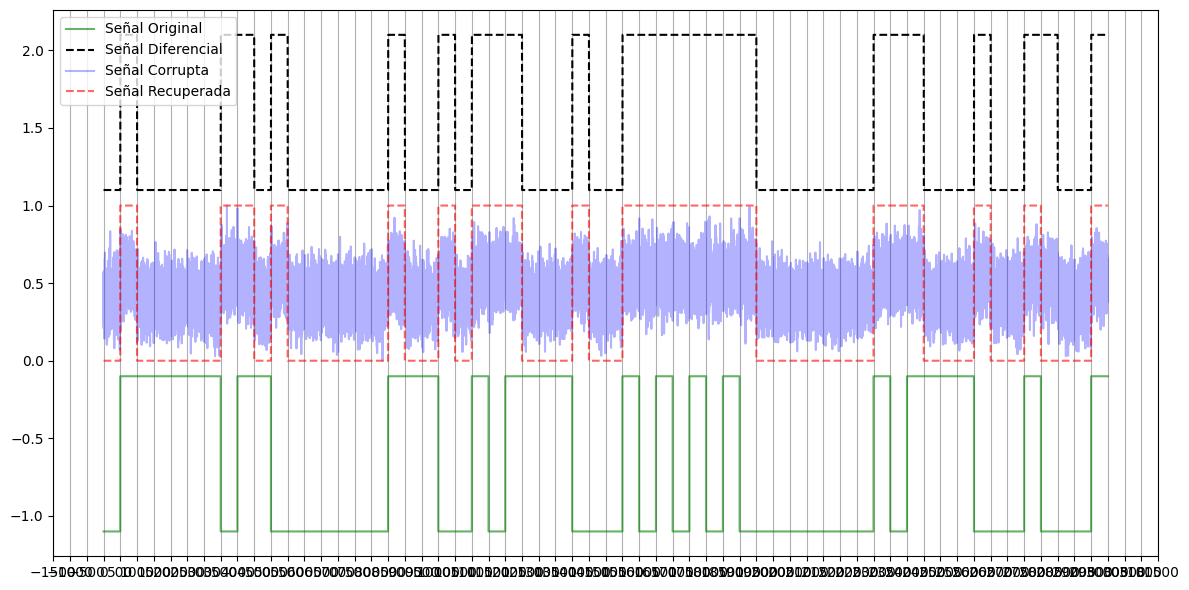

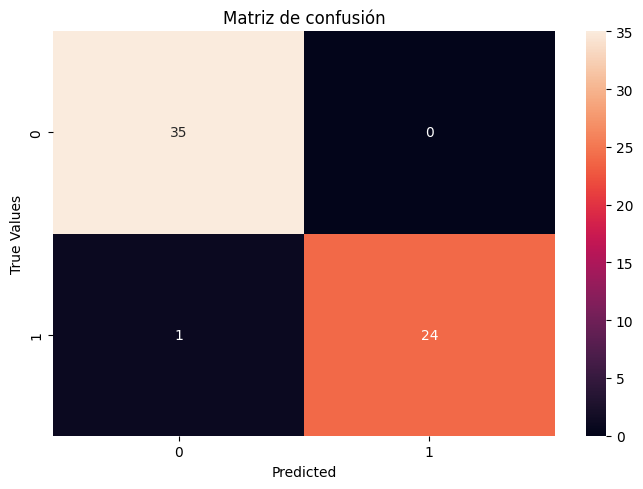

In [ ]:
Nsamples = 500
message_test_corrupt_4, message_test_orig_4, time_4 = generate_symbols(p_0=0.5,Nsymbols=60, Nsamples=Nsamples, var_noise=0.8, Diff=True) 
message_predict_4 = predict_simbol(message_test_corrupt_4, modelo, 500)

plt.figure(figsize=(12,6),tight_layout=True)  #modificar el tamaño (x,y)
plt.step(time_4, message_test_orig_4[0]-1.1, 'g', label='Señal Original', alpha=0.6)
plt.plot(time_4, message_test_orig_4[1]+1.1, '--', color = 'black',label='Señal Diferencial', alpha=1)
plt.step(time_4, message_test_corrupt_4.flatten(), 'b', label='Señal Corrupta', alpha=0.3)
plt.step(time_4, message_predict_4, '--r', label='Señal Recuperada', alpha=0.6)
plt.legend()
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(Nsamples))
plt.grid(axis='x')  # Solo cuadrícula vertical
plt.show()

matrix_4 = confusion_matrix(message_test_orig_4[1], message_predict_4)/Nsamples
plt.figure(figsize=(7,5),tight_layout=True)  #modificar el tamaño (x,y)
sns.heatmap(matrix_4, annot=True, fmt='g')
plt.title('Matriz de confusión')
plt.xlabel('Predicted')
plt.ylabel('True Values')
plt.show()



In [ ]:
from scipy.spatial.distance import hamming
print('P_e =', 1-hamming(message_test_orig_4[1], message_predict_4))


P_e = 1.0


In [ ]:
tamaño = 500

r = np.random.uniform(0,1,size=500)

s1 = np.flatiter([0]*tamaño) + r

s2 = np.flatiter([1]*tamaño) + r

signal = s1+s2
plt.plot(r) 
plt.plot(signal)

TypeError: cannot create 'numpy.flatiter' instances